In [107]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  


from sklearn import linear_model
plt.style.use("homework")

# Regularized Least Squares

In [2]:
rms = lambda x: np.sqrt(np.square(x).mean())

In [3]:
n = 100
m = 7
h = np.array((0.3, 0.5, 0.6, 0.4, 0.3, 0.2, 0.1))
ydes = np.zeros(106)
ydes[10:40] = 10
ydes[40:80] = -5

In [4]:
padding = np.zeros(n-1)
first_col = np.r_[h, padding]
first_row = np.r_[h[0], padding]
H = toeplitz(first_col, first_row)

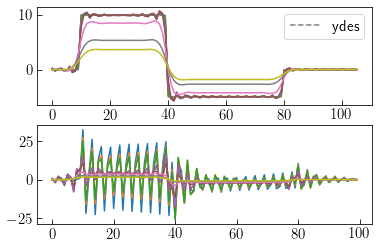

In [5]:
tradeoff = np.logspace(-4, 1)
tradeoff2 = [
    1E-4, 5E-4, 8E-4,
    9E-3, 1E-2, 5E-2,
    1, 5, 10 
]
inputs = []
errors = []
fig, (err_ax, input_ax) = plt.subplots(2, 1)
err_ax.plot(ydes, ls="--", color="gray", label="ydes")

for param in tradeoff2:
    A = np.vstack((
        H,
        np.sqrt(param) * np.eye(n)
    ))
    y = np.r_[ydes, np.zeros(n)]

    uopt, _, _, _ = np.linalg.lstsq(A, y, rcond=None)

    yhat = A@uopt
    err_ax.plot(yhat[:n+m-1])
    input_ax.plot(uopt, label=f"{param:e}")
    # errors.append(rms(yhat[:n+m-1] - ydes))
    # inputs.append(rms(uopt))
err_ax.legend()


Text(0, 0.5, 'RMS Control Input')

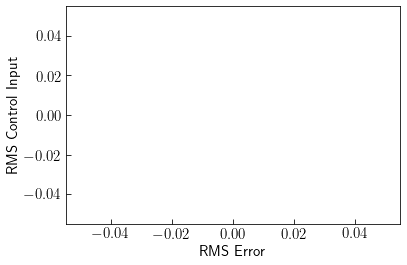

In [6]:
plt.plot(errors, inputs)
plt.xlabel(r"RMS Error")
plt.ylabel(r"RMS Control Input")

In [7]:
rng = np.random.default_rng(1)
n = 50
N = 300
N_test = 100

b_true = rng.normal(size=n)
v_true = 5
X = rng.random(size=(n, N))
y = np.sign(X.T @ b_true + v_true + 10 * rng.normal(size=N))

X_test = rng.random(size=(n, N_test))
y_test = np.sign(X_test.T @ b_true + v_true + 10 * rng.normal(size=N_test))

In [8]:
lm = linear_model.LinearRegression()
lm.fit(X.T, y)

yhat = np.sign(lm.predict(X.T))
print(f"Train error {(yhat != y).mean()}")
yhat = np.sign(lm.predict(X_test.T))
print(f"Test error {(yhat != y_test).mean()}")

Train error 0.26
Test error 0.34


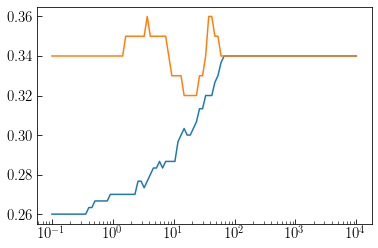

In [9]:
params = np.logspace(-1, 4, 100)
train_err = []
test_err = []
for p in params:
    lm = linear_model.Ridge(p)
    lm.fit(X.T, y)
    yhat = np.sign(lm.predict(X.T))
    train_err.append((yhat != y).mean())
    yhat = np.sign(lm.predict(X_test.T))
    test_err.append((yhat != y_test).mean())
plt.plot(params, train_err)
plt.plot(params, test_err)
plt.xscale("log")

In [10]:
norm = lambda x: np.sqrt(np.square(x).sum())

def gram_schmidt(a):
    q = []
    for i in range(len(a)):
        # orthogonalization
        q_tilde = a[i]
        for j in range(len(q)):
            q_tilde = q_tilde - (q[j] @ a[i])*q[j]
        if norm(q_tilde) <= 1E-10:
            print("Vectors are linearly dependent")
            print(f"GS algrorithm terminates at iteration {i+1}")
            return q
        # Normalization
        else:
            q_tilde = q_tilde / norm(q_tilde)
            q.append(q_tilde)
    # print("Vectors are linearly independent.")
    return q

In [11]:
A = np.array([
    [-1, 1, -1, 1],
    [-1, 3, -1, 3],
    [1, 3, 5, 7]
])
G = np.array(gram_schmidt(A))
print(G[0] @ G[1])

0.0


# Constrained Least Squares

In [12]:
rng = np.random.default_rng(1)
A = rng.normal(size=(20, 10))
C = rng.normal(size=(5, 10))
b = rng.normal(size=(20))
d = rng.normal(size=(5))

Ahat = np.block([
    [2*A.T@A, C.T],
    [C, np.zeros((5, 5))]
])
bhat = np.block([2*A.T@b, d])
xz, _, _, _ = np.linalg.lstsq(Ahat, bhat, rcond=None)
x = xz[:10]
print(C@x - d)

xln = np.linalg.pinv(C) @ d
print(norm(A@xln - b), norm(A@x - b))

[ 1.40998324e-14 -3.16413562e-15  1.15463195e-14  4.88498131e-15
  1.44328993e-15]
14.462934140241046 13.476883833693574


In [13]:
m = 10
n = 100
A = rng.normal(size=(m, n))
b = rng.normal(size=m)

# %timeit x1 = A.T @ np.linalg.inv(A @ A.T) @ b
# %timeit x2 = np.linalg.pinv(A) @ b
x1 = A.T @ np.linalg.inv(A @ A.T) @ b
x2 = np.linalg.pinv(A) @ b
print(norm(x1-x2))

The slowest run took 14.54 times longer than the fastest. This could mean that an intermediate result is being cached.
729 µs ± 560 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
154 µs ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.333338569992004e-16


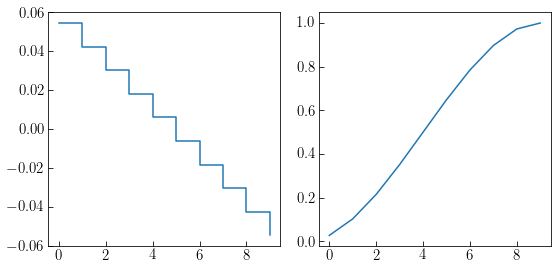

In [14]:
A = np.vstack((
    np.ones((1, 10)),
    np.arange(start=19, stop=0, step=-2)/2
))
b = np.array([0, 1])
f = np.linalg.pinv(A) @ b

P = np.zeros((10, 10))
for i in range(10):
    for j in range(i+1):
        P[i, j] = (i+1) - j - .5



fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1.step(np.arange(10), f, where="post")
ax2.plot(np.arange(10), P@f)

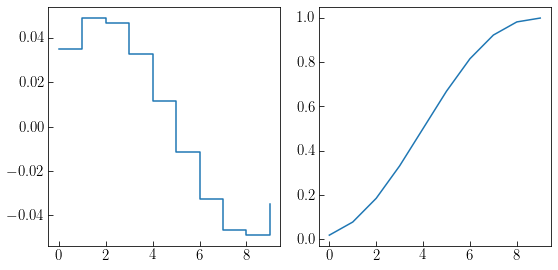

In [15]:
D = np.zeros((11, 10))
for i in range(10):
    D[i,i] = 1
    D[i+1, i] = -1
D[10, 9] = 1

KKT = np.block([
    [2*D.T@D, A.T],
    [A, np.zeros((2,2))]
])
fzopt = np.linalg.inv(KKT) @ np.concatenate((np.zeros(10), b), axis=-1)
f1 = fzopt[:10]

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1.step(np.arange(10), f1, where="post")
ax2.plot(np.arange(10), P@f1)

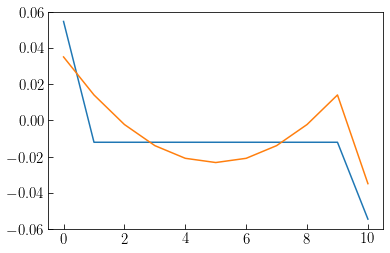

In [16]:
plt.plot(D@f)
plt.plot(D@f1)

In [17]:
print(f"Smallest force, norm: {np.linalg.norm(f):.4f} {np.linalg.norm(D@f):.4f}")
print(f"Smoothest force, norm: {np.linalg.norm(f1):.4f} {np.linalg.norm(D@f1):.4f}")


Smallest force, norm: 0.1101 0.0853
Smoothest force, norm: 0.1183 0.0683


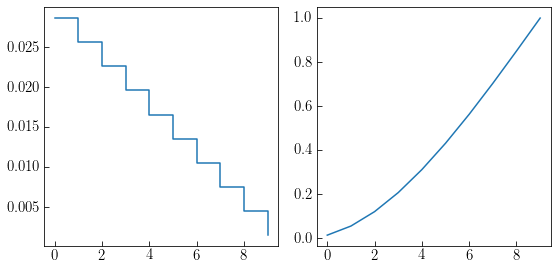

In [18]:
f2 = np.linalg.pinv(A[1].reshape(1, -1))
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
ax1.step(np.arange(10), f2, where="post")
ax2.plot(np.arange(10), P@f2)

In [19]:
512**2*128**3 / 1E9

549.755813888

## Image Steganography

In [20]:
from PIL import Image
img_path = "../img/img_proc/dump/lena.ppm"
im = Image.open(img_path).convert("L")

x = np.asarray(im).reshape(-1)
n = x.shape[0]
print("n =", n)

n = 65536


In [21]:
st = "I like corgi butts."
# st = "hello world"
bts = "".join(format(x, 'b').zfill(8) for x in bytearray(st, "utf-8"))
s = []
for c in bts:
    if c == "1":
        s.append(1)
    else:
        s.append(-1)
s = np.array(s)
k = s.shape[0]
print("k =", k)

k = 152


In [22]:
rng = np.random.default_rng(1)
D = rng.normal(size=(k, n))
D /= np.linalg.norm(D)
Ddagger = np.linalg.pinv(D)

Decoded successfully


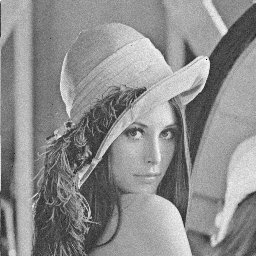

In [23]:
alpha = 1

z = Ddagger@(alpha * s - D@x)
xmod = (x + z).astype(np.uint8)#.clip(0, 255)
y = D@xmod
success = (np.sign(y) == s).all()
if success:
    print("Decoded successfully")
else:
    print(f"Number of incorrect symbols {(np.sign(y) != s).sum()}")

xim = xmod.reshape(im.size)
xim = Image.fromarray(xim, )

xim

# Linear Quadratic Control

$$
\begin{align*}
J_\text{output} &= \| y_1 \|^2 + \cdots + \| y_T \|^2 = \| C_1 x_1 \|^2 + \cdots + \| C_T x_T \|^2 \\
J_\text{input} &= \| u_1 \|^2 + \cdots + \| u_{T-1} \|^2
\end{align*}
$$

Optimization problem.

In [24]:
A = np.array([
    [0.855, 1.161, 0.667],
    [0.015, 1.073, 0.053],
    [-0.084, 0.059, 1.022]
])
B = np.array([-.076, -.139, .342]).reshape(3, -1)
C = np.array([.218, -3.597, -1.683]).reshape(-1, 3)

x_init = np.array([0.496, -.745, 1.394])
x_des = np.array([0, 0, 0])

In [25]:
import cvxpy as cp

In [26]:
rho = cp.Parameter(nonneg=True)
T = 99
n = 3
m = 1

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

cost = 0
constr = []
J1 = []
J2 = []
rho_vals = np.logspace(-2, 2)
for t in range(T):
    cost += cp.sum_squares(C@x[:, t+1]) + rho*cp.sum_squares(u[:, t])
    constr += [x[:, t+1] == A @ x[:, t] + B @ u[:, t]]
constr += [x[:, T] == x_des, x[:, 0] == x_init]
problem = cp.Problem(cp.Minimize(cost), constr)

for val in rho_vals:
    rho.value = val
    problem.solve()
    J1 += [cp.norm(C@x, 2).value]
    J2 += [cp.norm(u, 2).value]

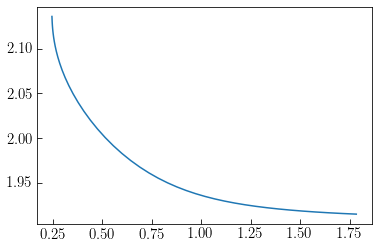

In [27]:
plt.plot(J2, J1)

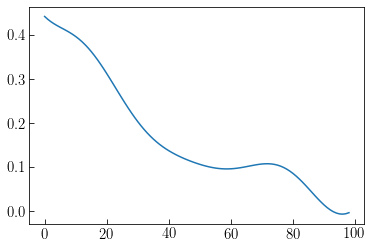

In [28]:
rho.val = 0.05
problem.solve()
y = []
for t in range(T):
    y += [C@x[:,t].value]
plt.plot(range(T), np.array(y))

In [29]:
rho = 1
T = 100
def lqr(A, B, C, x_init, x_des, T, rho):
    n = x_init.shape[0]
    m = B.shape[1]

    Ctilde = np.kron(np.eye(T), C)
    utilde = np.kron(np.eye(T-1), np.sqrt(rho)*np.eye(m))
    Atilde = np.block([
        [Ctilde, np.zeros((Ctilde.shape[0], utilde.shape[1]))],
        [np.zeros((utilde.shape[0], Ctilde.shape[1])), utilde]
    ])
    dup = np.concatenate((A, -np.eye(n)), axis=1)
    ul = np.kron(np.eye(T-1), dup)
    ur = np.kron(np.eye(T-1), B)
    ll = np.block([
        [np.eye(n), np.zeros((n, ul.shape[1]-n))],
        [np.zeros((n, ul.shape[1]-n)), np.eye(n)]
    ])
    C_tilde = np.block([
        [ul, ur],
        [ll, np.zeros((2*n, ur.shape[1]))]
    ])
    d_tilde = np.vstack([
        np.zeros((C_tilde.shape[0] - 2*n, 1)),
        x_init,
        x_des
    ])

(0.0, 100.0)

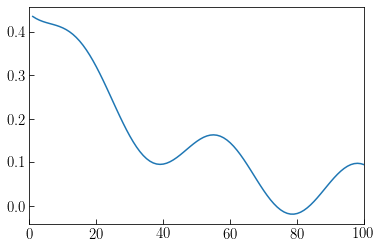

In [30]:
y = [C @ np.linalg.matrix_power(A, i) @ x_init for i in np.arange(1, 101)]
plt.plot(np.arange(1, 101), np.array(y).reshape(-1))
plt.xlim(0, 100)

# Nonlinear Least Squares

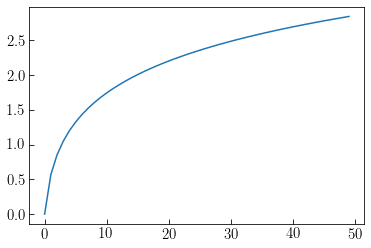

In [31]:
## W-Lambert function
# an important function with no analytical solution.
u = 5
xk = 1
lam = 1
kmax = 100
urange = np.arange(50)

f = lambda x, u: x*np.exp(x) - u

xopt = []
for u in urange:
    for k in range(kmax):
        xk1 = xk - (1+xk)*np.exp(xk) / (lam * (1 + xk)**2 * np.exp(2*xk)) * (xk * np.exp(xk) - u)

        if np.abs(f(xk1, u)) < 1E-6:
            # print("Break iteration", k)
            break
        elif f(xk1, u)**2 < f(xk, u)**2:
            lam = 0.8 * lam
            xk = xk1
        else:
            lam = 2*lam
    xopt += [xk1]

plt.plot(xopt);

Optimal rate: 0.072


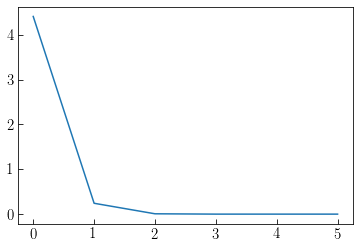

In [32]:
## Internal rate of return
def N_r(n, r):
    rc = []
    drc = []
    for i in range(n):
        rc += [1 / (1+r)**i]
        drc += [-i / (1+r)**(i-1)] 
    return np.array(rc), np.array(drc)


c = np.concatenate([
    -np.ones(3),
    0.3 * np.ones(5),
    0.6 * np.ones(6)
])
n = c.shape[0]
rk = 0
lam = 1

nrk = []
nr, dnr = N_r(n, rk)
for k in range(kmax):
    nrk += [(c@nr)**2]
    if nrk[-1] < 1E-6:
        break
    rk1 = rk - c@dnr / (lam + (c@dnr)**2) * c@nr

    nr1, dnr1 = N_r(n, rk1)
    
    if (c@nr1)**2 < nrk[-1]:
        lam = 0.8 * lam
        nr = nr1
        rk = rk1
        dnr = dnr1
    else:
        lam = 2*lam

print(f"Optimal rate: {rk:.3f}")
plt.plot(nrk)

[8.29759001 3.24499615 1.45166475 0.83195554 0.74851077 0.74137315
 0.74093672 0.74091734 0.74091672 0.74091671 0.74091671 0.74091671]
[ 5.21403924 -0.23428705]


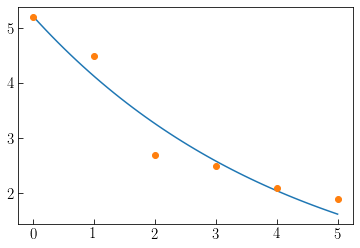

In [33]:
## Nonlinear model fitting
from numpy.linalg import norm

x = np.arange(6)
y = np.array([5.2, 4.5, 2.7, 2.5, 2.1, 1.9])

f = lambda theta: theta[0] * np.exp(theta[1] * x) - y
Df = lambda theta: np.array([np.exp(theta[1]*x), x*theta[0]*np.exp(theta[1]*x)]).T

tk = np.array([0, 0])
lam = 1

error = [norm(f(tk))]

for k in range(kmax):
    A = np.vstack([Df(tk), np.sqrt(lam) * np.eye(len(tk))])
    b = np.concatenate((Df(tk) @ tk - f(tk), np.sqrt(lam)*tk))
    tk1, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    error += [norm(f(tk1))]

    if norm(2*Df(tk1).T@f(tk1)) < 1E-5:
        tk = tk1
        break
    elif norm(f(tk1)) < norm(f(tk)):
        tk = tk1
        lam = 0.8 * lam
    else:
        lam = 2 * lam

print(np.array(error))
print(tk)
xt = np.linspace(0, 5)
yt = tk[0] * np.exp(tk[1]*xt)
plt.plot(xt, yt)
plt.plot(x, y, "o");

In [34]:
def nonlin_lstsq(f, Df, tk, lam=1, kmax=100, tol=1E-6):
    error = [norm(f(tk))]

    for k in range(kmax):
        A = np.vstack([Df(tk), np.sqrt(lam) * np.eye(len(tk))])
        b = np.concatenate((Df(tk) @ tk - f(tk), np.sqrt(lam)*tk))
        tk1, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        error += [norm(f(tk1))]

        if norm(2*Df(tk1).T@f(tk1)) < 1E-5:
            tk = tk1
            break
        elif norm(f(tk1)) < norm(f(tk)):
            tk = tk1
            lam = 0.8 * lam
        else:
            lam = 2 * lam
    return tk, np.array(error)

[6.20449459 3.93976487 3.52047342 3.36254128 3.2619575  3.21883257
 3.19367079 3.17810772 3.16778733 3.1605326  3.15517294 3.1510587
 3.14780677 3.14517788 3.14301508 3.14121106 3.13968977 3.13839566
 3.13728701 3.13633174 3.1355047  3.13478579 3.13415874 3.13361019
 3.13312905 3.13270606 3.13233344 3.13200456 3.13171381 3.13145638
 3.13122812 3.13102549 3.13084541 3.13068521 3.13054257 3.13041546
 3.13030212 3.130201   3.13011072 3.1300301  3.12995808 3.12989371
 3.12983617 3.12978472 3.12973872 3.12969757 3.12966076 3.12962784
 3.12959838 3.12957203 3.12954845 3.12952736 3.12950848 3.1294916
 3.12947649 3.12946297 3.12945088 3.12944005 3.12943037 3.12942171
 3.12941396 3.12940703 3.12940083 3.12939528 3.12939032 3.12938588
 3.12938191 3.12937836 3.12937518 3.12937234 3.12936979 3.12936752
 3.12936548 3.12936366 3.12936204 3.12936058 3.12935928 3.12935811
 3.12935707 3.12935614 3.1293553  3.12935456 3.12935389 3.1293533
 3.12935276 3.12935228 3.12935186 3.12935148 3.12935113 3.1293508

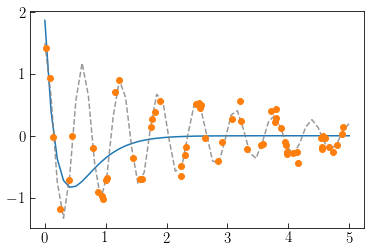

In [39]:
## Decaying sinusoid
N = 60
x = np.random.uniform(0, 5, N)
theta = [1.5, -.4, 10, .1]
y = theta[0] * np.exp(theta[1]*x)*np.cos(theta[2]*x + theta[3]) + np.random.randn(N)*.1


f = lambda th: th[0] * np.exp(th[1] * x) * np.cos(th[2]*x + th[3]) - y
Df = lambda th: np.array([
    np.exp(th[1] * x) * np.cos(th[2]*x + th[3]),
    x * th[0] * np.exp(th[1] * x) * np.cos(th[2]*x + th[3]),
    -x * th[0] * np.exp(th[1] * x) * np.sin(th[2]*x + th[3]),
    -th[0] * np.exp(th[1] * x) * np.sin(th[2]*x + th[3]),
]).T


tk = np.array([1, 0, 3, 0])

tk, error = nonlin_lstsq(f, Df, tk)

print(error)
print(tk)
xt = np.linspace(0, 5)
yt = tk[0] * np.exp(tk[1]*xt) * np.cos(tk[2]*xt + tk[3])  # forgot to update this...
y_orig = theta[0] * np.exp(theta[1]*xt)*np.cos(theta[2]*xt + theta[3])
plt.plot(xt, yt)
plt.plot(xt, y_orig, "--", color="gray", alpha=0.8)
plt.plot(x, y, "o");

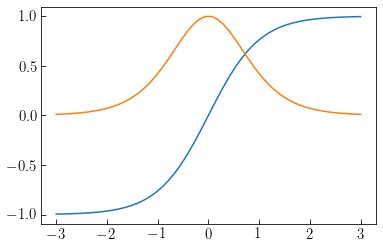

In [47]:
# Neural Network
sigmoid = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
dSigmoid = lambda x: 1 - np.square((sigmoid(x)))
# The solutions manual gives a different, and wrong, derivative.
# dSigmoid = lambda x: 4 / np.square(np.exp(x) - np.exp(-x))

x = np.linspace(-3, 3)

plt.plot(x, sigmoid(x))
plt.plot(x, dSigmoid(x))

NN residual 0.010. Linear residual 18.532
NN coef [-1.24799625e+02  5.47909323e-02 -9.64336605e-02 -6.57830780e-01
 -2.62433356e+02 -3.27788652e-02  3.02691903e-03  1.84255219e-02
  1.04902565e+02 -5.86850862e-02 -1.05212456e-01 -6.73007566e-01
 -5.59111229e+00]
Linear coef [-0.03417652 -0.04016496  0.01157779]


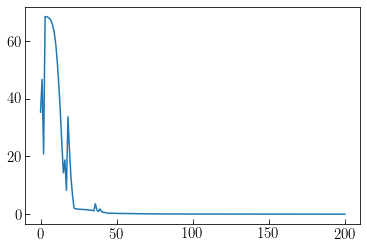

In [130]:
N = 200
x = np.random.uniform(-1, 1, (N, 2))
y = np.prod(x, axis=1)
p = 13
tk = np.random.normal(size=p)
# tk = np.ones(p)

def nn(theta, x=x):
    xAff = np.hstack((x, np.ones(x.shape[0])[:,np.newaxis]))
    w1 = xAff @ theta[1:4]
    w2 = xAff @ theta[5:8]
    w3 = xAff @ theta[9:12]
    fhat = theta[0] * sigmoid(w1) + theta[4] * sigmoid(w2) + theta[8] * sigmoid(w3) + theta[12]
    return fhat

def f_nn(theta):
    return nn(theta) - y

def df_nn(theta):
    xAff = np.hstack((x, np.ones(x.shape[0])[:,np.newaxis]))
    w1 = xAff @ theta[1:4]
    w2 = xAff @ theta[5:8]
    w3 = xAff @ theta[9:12]

    grad = np.stack([
        sigmoid(w1),
        theta[0] * x[:,0] * dSigmoid(w1),
        theta[0] * x[:,1] * dSigmoid(w1),
        theta[0] * dSigmoid(w1),
        sigmoid(w2),
        theta[4] * x[:,0] * dSigmoid(w2),
        theta[4] * x[:,1] * dSigmoid(w2),
        theta[4] * dSigmoid(w2),
        sigmoid(w3),
        theta[8] * x[:,0] * dSigmoid(w3),
        theta[8] * x[:,1] * dSigmoid(w3),
        theta[8] * dSigmoid(w3),
        np.ones(N)
    ])
    return grad.T

theta_opt, errors = nonlin_lstsq(f_nn, df_nn, tk, 1E-5, 200)
nn_resid = norm(f_nn(theta_opt))
plt.plot(errors)

xAff = np.hstack((x, np.ones(x.shape[0])[:,np.newaxis]))
tlst, resids, _, _ = np.linalg.lstsq(xAff, y, rcond=None)

print(f"NN residual {nn_resid:.3f}. Linear residual {resids[0]:.3f}")
print(f"NN coef {theta_opt}")
print(f"Linear coef {tlst}")

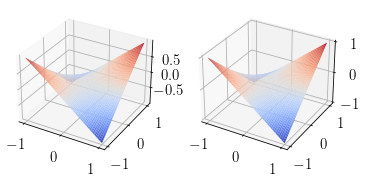

In [120]:
xgrd = np.linspace(-1, 1)
xgrd1, xgrd2 = np.meshgrid(xgrd, xgrd)
xgrd = np.array([xgrd1.reshape(-1), xgrd2.reshape(-1)]).T
fhat = nn(theta_opt, xgrd).reshape(50, 50)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
axs[0].plot_surface(xgrd1, xgrd2, fhat, cmap=cm.coolwarm)
axs[1].plot_surface(xgrd1, xgrd2, xgrd1 * xgrd2, cmap=cm.coolwarm)